In [0]:
from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd
from functools import partial
import jax
import jax.numpy as jp
import jax.scipy as jsp
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, ConvTranspose, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid, BatchNorm # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
import matplotlib.pyplot as plt # visualization
import numpy as np
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
from jax.ops import index, index_add, index_update
import os, time

In [0]:
def ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = jp.array([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = sigmoid(th[0][0:1])
    p_2_0 = sigmoid(th[1][0:1])
    p = jp.stack([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)], axis=1)
    # print('p',p,p.shape)
    p_1 = jp.reshape(sigmoid(th[0][1:5]), (4, 1))
    p_2 = jp.reshape(sigmoid(th[1][1:5]), (4, 1))
    P = jp.stack([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], axis=1).reshape((4,4))
    # print('P',P,P.shape)
    # print('inv', jsp.linalg.inv(jp.eye(4)-gamma*P), jsp.linalg.inv(jp.eye(4)-gamma*P).shape)
    M = -jp.dot(p, jsp.linalg.inv(jp.eye(4)-gamma*P))
    # print('M',M)
    L_1 = jp.dot(M, jp.reshape(payout_mat_1, (4, 1)))
    L_2 = jp.dot(M, jp.reshape(payout_mat_2, (4, 1)))
    # print('L_1',L_1.reshape(-1)[0])
    # print('L_2',L_2.reshape(-1)[0])
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls


Jax time: 3.636260747909546


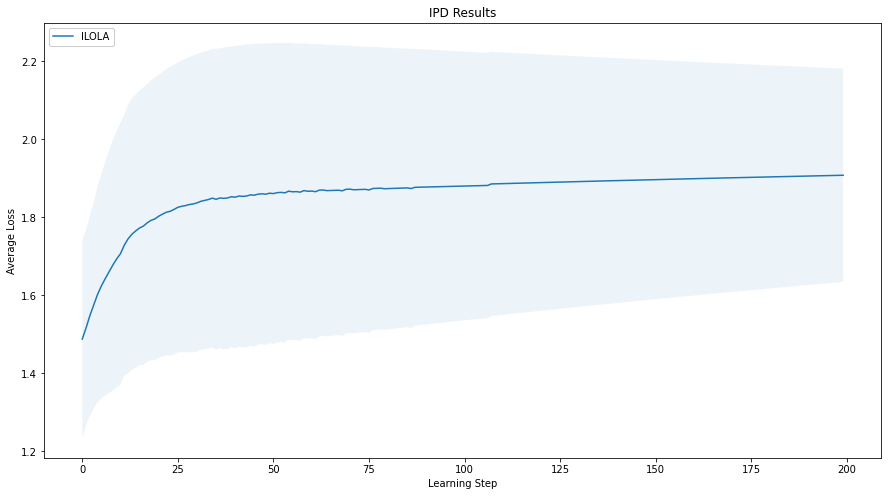

In [0]:
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NAIVE'''

def init_th(dims, std, rng):
  th = []
  init=random.normal(rng, shape=(jp.sum(jp.array(dims)),))
  if std > 0:
    init*=std
  for i in range(len(dims)):
    th.append(init[:dims[i]])
    init=init[dims[i]:]
  return jp.array(th)


def ilola(Ls, th, momentum, hp):
    grad_L = jacobian(Ls)(th)  # n x n x d
    xi = jp.einsum('iij->ij', grad_L)
    full_hessian = jax.hessian(Ls)(th)
    off_diag_hessian = full_hessian
    proxy_momentum = -hp['alpha'] * xi + hp['gamma'] * momentum
    for i in range(th.shape[0]):
        off_diag_hessian = index_update(off_diag_hessian, index[i, i, :, :, :], 0)
    second_term = jp.einsum('iim->im', jp.einsum('ijklm,jk->ilm', off_diag_hessian, proxy_momentum))
    denom = 1 / (xi + 1e-10)
    diag_hessian = jp.einsum('ij,kl->ijkl', proxy_momentum, denom)
    for i in range(th.shape[0]):
        diag_hessian = index_update(diag_hessian, index[i, :, i, :], 0)
    third_term = jp.einsum('iij->ij', jp.einsum('ijkl,mij->mkl', diag_hessian, grad_L))
    grads = xi + second_term + third_term
    step = hp['eta'] * grads
    return th - step.reshape(th.shape), Ls(th), hp['gamma'] * momentum - step


def main():
    rng = jax.random.PRNGKey(1234)

    gamma = 0.96
    dims, Ls = ipd(gamma)
    num_runs = 100
    num_epochs = 200
    std = 1
    algo_list = ['ILOLA']
    theta = vmap(partial(init_th, dims, std))(jax.random.split(rng, num_runs))
    hp = {'eta': 0.001, 'alpha': 10.0, 'a': 0.5, 'b': 0.5, 'lambda':1.0, 'gamma': 0.9}

    t1 = time.time()
    plt.figure(figsize=(15, 8))
    for algo in [s.lower() for s in algo_list]:
        losses_out = np.zeros((num_runs, num_epochs))
        update_fn = jit(vmap(partial(ilola, Ls), in_axes=(0, 0, None), out_axes=(0, 0, 0)))
        th, momentum = theta, jp.zeros_like(theta)
        for k in range(num_epochs):
            th, losses, momentum = update_fn(th, momentum, hp)
            # print(momentum[0])
            losses_out[:, k] = (1-gamma)*losses[:, 0]
        mean = np.mean(losses_out, axis=0)
        dev = np.std(losses_out, axis=0)
        plt.plot(np.arange(num_epochs), mean)
        plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.08)

    plt.title('IPD Results')
    plt.xlabel('Learning Step')
    plt.ylabel('Average Loss')
    plt.legend(algo_list, loc='upper left', frameon=True, framealpha=1, ncol=3)
    print('Jax time:', time.time()-t1)
    plt.show()

if __name__ == "__main__":
    main()